# Home Credit Default Risk Analysis
The scenario for this analysis is that I am seeking to provide risk evaluation as a service for retail banks. Consequently, it is my mission to build models that can capture statistical patterns in the defaults on bank loans. In doing this, I download a dataset that captures a lot of data on consumers, including whether they default on loans (https://www.kaggle.com/competitions/home-credit-default-risk/data). As I am not sure what the most crucial problems are for my clients, I decide to create a range of different models in order to have a robust and diversified offering with future clients. 

In doing this, I will be:
- Performing EDA.
- Applying statistical inference procedures.
- Using machine learning to solve business problems.
- Deploying multiple machine learning models.

You are not yet sure, what is the most crucial problem for your potential clients, so you had a meeting with your friend to discuss how your proof-of-concept (POC) product should look like. After a lot of arguing, you both agreed to create a number of different models so that you have a robust and diversified offering when you get your first meeting with the potential clients. You are eager to investigate the dataset and see what you can predict, so you propose that you come up with interesting features to analyze and predict - this way, you'll focus on building a solid offering, and she can work on getting meetings with the banks.

## Key Assumptions
To guide my analysis, I make a few claims which I believe to be true.

#### About the potential clients:
- Above all, banks seek to reduce the number of defaults on loans.
- Different banks assess risk differently, and may take different metrics into consideration.
- Banks generally appreciate an interpretable and transparent model, though the degree to which this is the case varies.
- Banks require sandbox environments in which they can test out solutions in a safe and secure way.

#### About the data
- The data represented in the dataset is representative of real-life data, especially that of my clients.
- The data comprises the most vital variables of interest in predicting default rates
- Variables are reliable, insofar as they would be consistent if we sought to recreate the dataset. This is especially the case of the target variable of whether someone defaults, as this is what is of the utmost importance for us to build supervised machine learning algorithms.
- The patterns present in this data of **past** loans apply equally to **future** loans. While this is rarely the case in real life, we in this scenario must assume it.

## Overall Objectives
In this analysis, I aim to:
- Discover the variables, whether organic from the source or feature-engineered, that are most pivotal in deciding whether a person defaults on a loan. This will be through both from an inferential as well as predictive standpoint.
- Understand data imbalances, messiness, and overly-primitive constructions that may hinder how we can interpret their findings
- Build an array of **transparent** models which seek to maximize the predictive ability of spotting defaults - **as measured through various different lenses**. These will be with varying degrees of interpretability versus accuracy, so that they may suit whatever context a potential client may have.
- Deploy models to an efficient mode of access (Google Cloud Platform, , so that clients can easily test, iterate, and implement the solutions.

### Importing Necessary Libraries

In [37]:
import json
import math
import time
from collections import Counter

import joblib
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import scipy.sparse
import seaborn as sns
import shap
import statsmodels.api as sm
from catboost import CatBoostClassifier
from flask import Flask, jsonify, request
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from IPython.display import Image, display
from lightgbm import LGBMClassifier
from scipy import stats
from scipy.stats import mode, randint, uniform
from scipy.stats.mstats import winsorize
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin, clone
from sklearn.calibration import CalibratedClassifierCV
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    StackingClassifier,
    VotingClassifier,
)
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    mean_squared_error,
    r2_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    StratifiedKFold,
    cross_val_score,
    learning_curve,
    train_test_split,
)
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from statsmodels.formula.api import logit
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from utilities import (
    BalancedBaggingClassifier,
    DataPreprocessor,
    TailClipper,
    Winsorizer,
    append_class_metrics,
    calculate_missing_data,
    calculate_vif_and_drop_high_vif_iterative,
    check_linear_logit_assumption,
    convert_boolean_columns_to_int,
    drop_highly_correlated_features,
    encode_and_drop_high_cardinality,
    evaluate_model_performance,
    full_eda_visualization,
    get_column_aggregations,
    get_feature_names,
    identify_columns_to_drop,
    impute_data_median_mode,
    inspect_negative_value_distributions_with_descriptions,
    is_binary_column,
    merge_tables_in_chunks,
    plot_learning_curve,
    plot_target_distribution,
    preprocess_and_fit_logit,
    print_column_descriptions,
    robust_scale_dataframe,
    visualize_missing_data,
    winsorize_dataframe,
)
from xgboost import XGBClassifier

# Overview of Data
A variety of different table are present in the data. These can briefly be understood through the Entity Relationship Diagram of below:

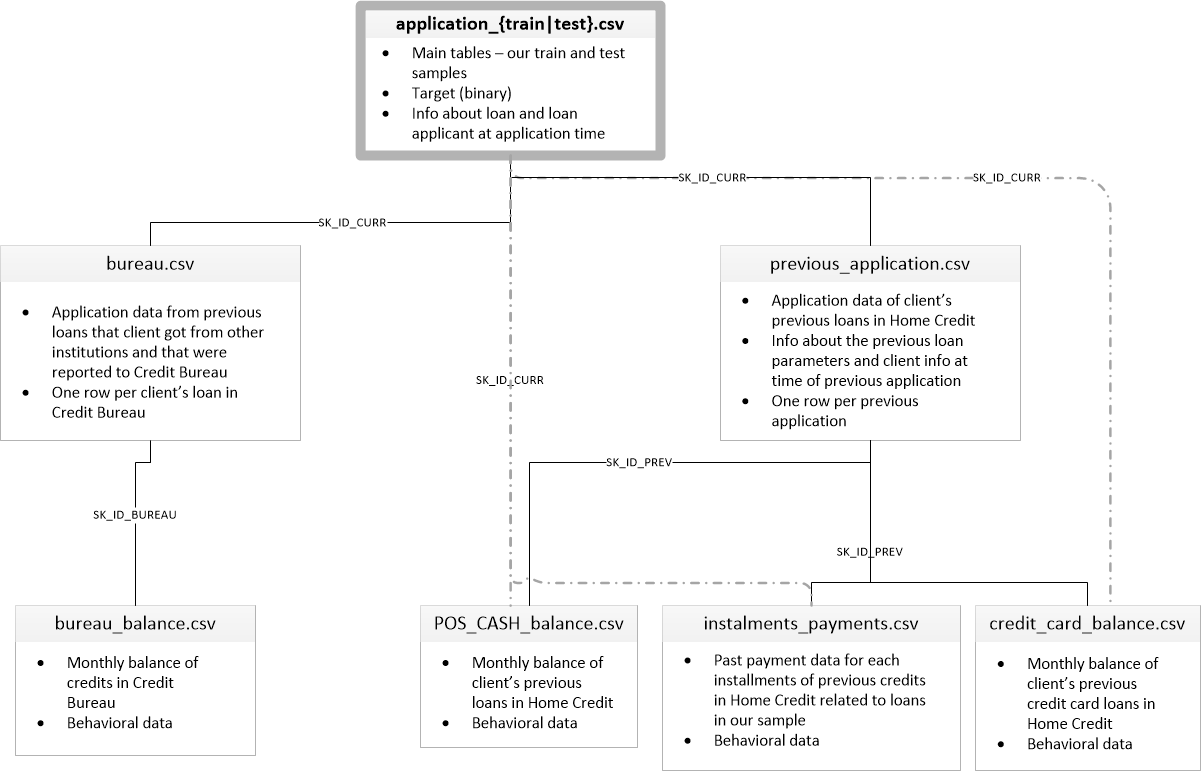

In [2]:
print("\n")
display(Image(filename="Entity Relationship Diagram.png"))
print("\n")

As can be seen, be have the following tables:

1. **application_{train|test}.csv**
This is the main table, broken into two files for Train (with TARGET) and Test (without TARGET). We will only be using the Train file for training and choosing a model, and then we will be using the Test file to check the external validity (i.e., generalizability) of our models.
Static data for all applications. One row represents one loan in our data sample.

2. **bureau.csv**
All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).
For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.

3. **bureau_balance.csv**
Monthly balances of previous credits in Credit Bureau.
This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e the table has (#loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits) rows.


5. **POS_CASH_balance.csv**
Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.
This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credits * # of months in which we have some history observable for the previous credits) rows.

6. **credit_card_balance.csv**
Monthly balance snapshots of previous credit cards that the applicant has with Home Credit.
This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credit cards * # of months where we have some history observable for the previous credit card) rows.

7. **previous_application.csv**
All previous applications for Home Credit loans of clients who have loans in our sample.
There is one row for each previous application related to loans in our data sample.

8. **installments_payments.csv**
Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample.
There is a) one row for every payment that was made plus b) one row each for missed payment.
One row is equivalent to one payment of one installment OR one installment corresponding to one payment of one previous Home Credit credit related to loans in our sample.

9. **HomeCredit_columns_description.csv**
This file contains descriptions for the columns in the various data files. This was used when merging the data, and will also be used later to explain important features.

# Merging the Data
Next I begin to merge the data into a single flat table. In doing so, I begin to merge data from the bottom and up. What I want to do is, since every row in the main table refers to a person and their loan, I want all the sub-tables to add more data to this person. In other words, all data from the sub-tables should be added as new columns, so that they can individually be treated as features. To do this, for all the one-to-many relationships, I transform continuous numeric features by taking the mean value of the feature and adding it as a new column to the parent table, whereas for non-numeric data it takes the mode that appears. the primary and foreign keys at times differ, I, as mentioned, start from the bottom, and move my way up in merging tables.

For the code to be reproducible, as well as save time and storage, I only run the opening of the final table (having run the mergings before)

In [3]:
main_table = pd.read_csv("data/application_train.csv
POS_CASH_balance = pd.read_csv("data/POS_CASH_balance.csv")
main_table_1 = merge_tables_in_chunks(
    main_table,
    POS_CASH_balance,
    "SK_ID_CURR",
    "SK_ID_CURR",
    sub_df_name="POS_CASH",
    chunk_size=100000,

installments_payments = pd.read_csv("data/installments_payments.csv")
main_table_2 = merge_tables_in_chunks(
    main_table_1,
    installments_payments,
    "SK_ID_CURR",
    "SK_ID_CURR",
    sub_df_name="installments",
    chunk_size=100000,

credit_card_balance = pd.read_csv("data/credit_card_balance.csv")
main_table_3 = merge_tables_in_chunks(
    main_table_2,
    credit_card_balance,
    "SK_ID_CURR",
    "SK_ID_CURR",
    sub_df_name="credit_card",
    chunk_size=100000,

bureau = pd.read_csv("data/bureau.csv")
bureau_balance = pd.read_csv("data/bureau_balance.csv")
bureau_merged = merge_tables_in_chunks(
    bureau,
    bureau_balance,
    "SK_ID_BUREAU",
    "SK_ID_BUREAU",
    sub_df_name="bureau_balanced",
    chunk_size=100000,

main_table_4 = merge_tables_in_chunks(
    main_table_3,
    bureau_merged,
    "SK_ID_CURR",
    "SK_ID_CURR",
    sub_df_name="bureau",
    chunk_size=100000,

previous_application = pd.read_csv("data/previous_application.csv")
main_table_5 = merge_tables_in_chunks(
    main_table_4,
    previous_application,
    "SK_ID_CURR",
    "SK_ID_CURR",
    sub_df_name="previous_application",
    chunk_size=100000,
)

In [4]:
main_table_5.to_csv("final_table.csv", index=False)

In [5]:
final_table = pd.read_csv("final_table.csv")

# Data Cleaning
Ultimately, the new table has a total of 212 different columns, with the same number of rows (as we purposefully only wanted to increase the depth of information we had on existing applicants and their loans). No duplicate rows are found, though there are a variety of columns with missing features as can be seen in the boxplot and the accompanying graphs. I make the decision to drop all columns which have more than 60% of missing data, as well as non-numeric columns that simply have more than 30% of missing data. I make this decision as I am otherwise afraid that I would be introducing too much noise to the dataset. In relation to also dropping non-numeric columns with more than 30% of missing data, I choose to do this as I will later be using data imputation based on the mode class, which would introduce a large degree of (somewhat meaningless) homogeneity in the data otherwise. This is not the case with continuous variables, for which I will use KNN, which, as opposed to data imputation based on the mean, does not only impute a single value, but rather a value based on the nearest neighbors of other features and choosing the middle point using Euclidean distance. As such, it will vary more, which I think will add more relevant meaning.

In [6]:
final_table.shape

(307511, 212)

In [7]:
print("Duplicate rows:", final_table.duplicated().sum())

Duplicate rows: 0


 There are 0 missing values in the Target Column
Number of columns with no missing data: 58


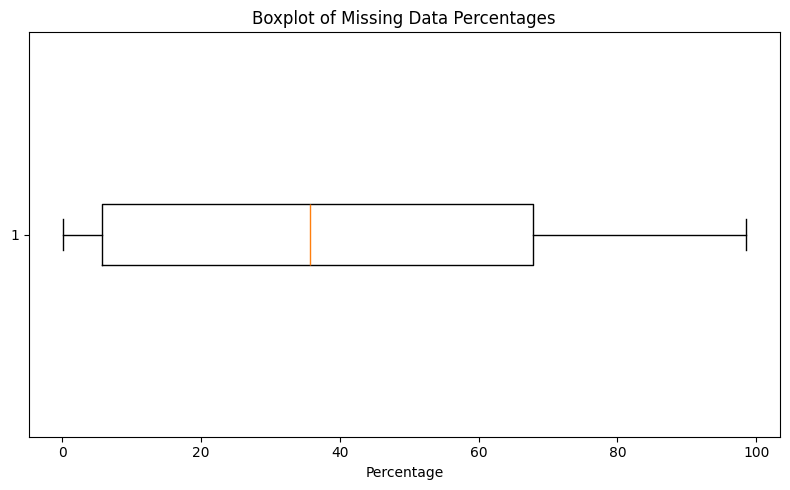

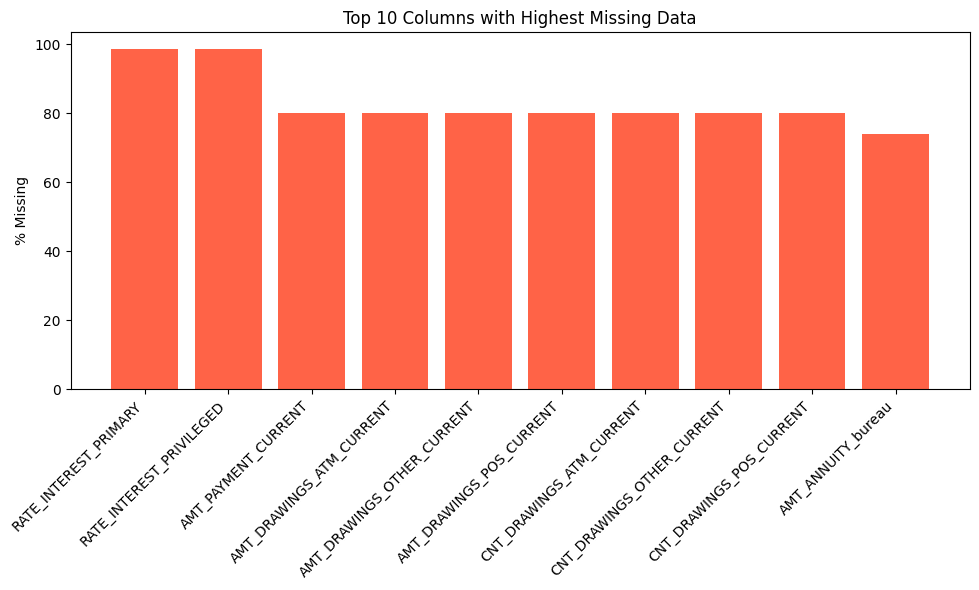

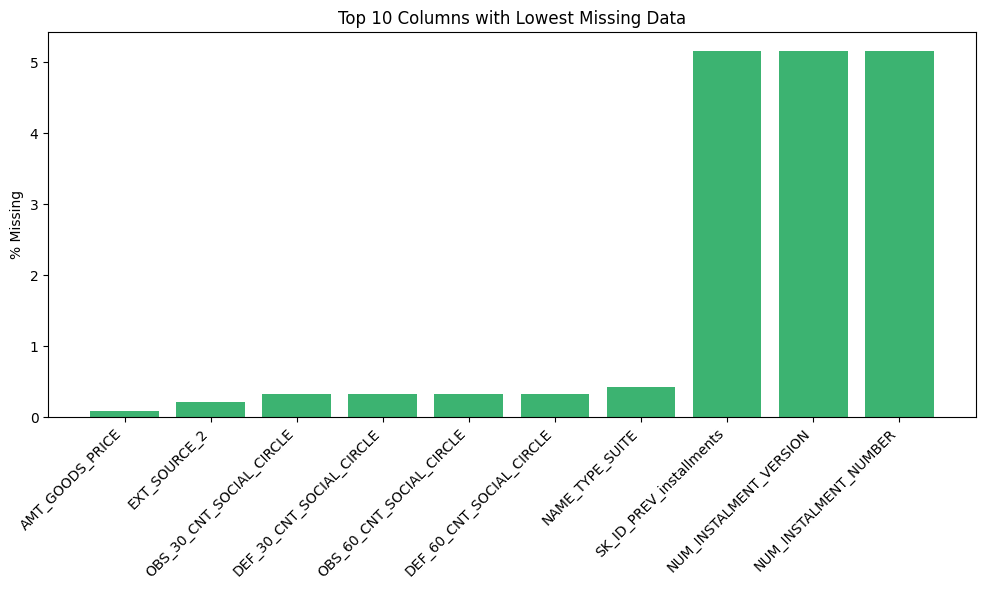

In [8]:
missing = calculate_missing_data(final_table)

missing_target = final_table["TARGET"].isna().sum()
print(f" There are {missing_target} missing values in the Target Column")

num_complete_columns = sum(1 for pct in missing.values() if pct == 0.0)
print(f"Number of columns with no missing data: {num_complete_columns}")

missing_columns_only = {col: pct for col, pct in missing.items() if pct > 0.0}

visualize_missing_data(missing_columns_only)

## Train-Test Split
Before I drop the variables the variables, I first split the data into a train and test set, as this type of cleaning is not anything I want to happen to my machine learning data, as this for practical reasons needs to be embedded into the pipeline. Hence, I first make a split of the data, and after this I create a duplicate version of the training data which I will use for the inferential analysis. I make a stratified split, so that the overall representations of the data are in proportion indicative of the test set. This help

In [9]:
X = final_table.drop("TARGET", axis=1)
y = final_table["TARGET"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)

inf_train = X_train.copy()
inf_train["TARGET"] = y_train

print("Training data shape:", inf_train.shape)
inf_train.head()

Training data shape: (276759, 212)


SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
234502      371646         Cash loans           F            N   
34261       139700         Cash loans           F            Y   
265488      407492         Cash loans           F            N   
172932      300400         Cash loans           F            Y   
88035       202199         Cash loans           F            N   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
234502               Y             0          180000.0    781920.0   
34261                Y             1          202500.0   1006920.0   
265488               N             0           36000.0    814041.0   
172932               N             1          135000.0   2013840.0   
88035                N             0          157500.0    675000.0   

        AMT_ANNUITY  AMT_GOODS_PRICE  ... CNT_PAYMENT NAME_YIELD_GROUP  \
234502      28215.0         675000.0  ...        24.0       low_action   
34261       42790.5         900000.0  ...        20.4           middle   
265488      23931.0         679500.0  ...         6.0              XNA   
172932      55507.5        1800000.0  ...        32.5              XNA   
88035       65889.0         675000.0  ...        10.0       low_normal   

                   PRODUCT_COMBINATION DAYS_FIRST_DRAWING DAYS_FIRST_DUE  \
234502  POS household without interest           365243.0         -336.0   
34261              Cash X-Sell: middle           291743.2        -1407.6   
265488                     Card Street           182499.0         -304.5   
172932                            Cash           182399.5         -573.5   
88035      POS mobile without interest           365243.0         -491.0   

        DAYS_LAST_DUE_1ST_VERSION  DAYS_LAST_DUE  DAYS_TERMINATION  \
234502                      354.0       365243.0          365243.0   
34261                     72451.6        -1076.2            -733.0   
265488                   182588.0       182588.0          182592.0   
172932                   182384.0         -346.5          182388.0   
88035                      -221.0         -221.0            -202.0   

        NFLAG_INSURED_ON_APPROVAL  TARGET  
234502                        0.0       0  
34261                         0.0       0  
265488                        0.0       0  
172932                        0.0       0  
88035                         0.0       0  

[5 rows x 212 columns]

In [10]:
columns_to_drop = identify_columns_to_drop(inf_train)
print(f"there are {len(columns_to_drop)} columns that need to be dropped")

inf_train_dropped = inf_train.drop(columns=columns_to_drop)

print("Columns successfully dropped!")

there are 70 columns that need to be dropped
Columns successfully dropped!


# Exploratory Data Analysis
Due to the vast nature of this data, I want to avoid manually going through every single column in terms of their relation to the target variable (i.e., whether people default or not), as this would take up a very large amount of space. Instead, I use code that looks a the code from a more high-level position.

In [11]:
inf_train_dropped.info()

<class 'pandas.core.frame.DataFrame'>
Index: 276759 entries, 234502 to 285162
Columns: 142 entries, SK_ID_CURR to TARGET
dtypes: float64(70), int64(41), object(31)
memory usage: 301.9+ MB


In [12]:
inf_train_dropped.describe()

SK_ID_CURR   CNT_CHILDREN  AMT_INCOME_TOTAL    AMT_CREDIT  \
count  276759.000000  276759.000000      2.767590e+05  2.767590e+05   
mean   278194.207860       0.416785      1.688532e+05  5.992153e+05   
std    102766.554286       0.720201      2.477892e+05  4.025182e+05   
min    100002.000000       0.000000      2.565000e+04  4.500000e+04   
25%    189166.500000       0.000000      1.125000e+05  2.700000e+05   
50%    278223.000000       0.000000      1.462500e+05  5.135310e+05   
75%    367113.500000       1.000000      2.025000e+05  8.086500e+05   
max    456255.000000      19.000000      1.170000e+08  4.050000e+06   

         AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  \
count  276749.000000     2.765070e+05               276759.000000   
mean    27109.409615     5.385873e+05                    0.020885   
std     14503.646680     3.694527e+05                    0.013852   
min      1615.500000     4.050000e+04                    0.000290   
25%     16537.500000     2.385000e+05                    0.010006   
50%     24903.000000     4.500000e+05                    0.018850   
75%     34596.000000     6.795000e+05                    0.028663   
max    258025.500000     4.050000e+06                    0.072508   

          DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  ...  DAYS_DECISION  \
count  276759.000000  276759.000000      276759.000000  ...  261934.000000   
mean   -16032.153068   63707.038127       -4987.839640  ...    -919.628207   
std      4363.962380  141185.613623        3523.358217  ...     577.690565   
min    -25229.000000  -17912.000000      -24672.000000  ...   -2922.000000   
25%    -19675.000000   -2759.000000       -7483.000000  ...   -1247.000000   
50%    -15745.000000   -1214.000000       -4504.000000  ...    -789.200000   
75%    -12406.000000    -290.000000       -2013.000000  ...    -467.000000   
max     -7489.000000  365243.000000           0.000000  ...      -2.000000   

       SELLERPLACE_AREA    CNT_PAYMENT  DAYS_FIRST_DRAWING  DAYS_FIRST_DUE  \
count      2.619340e+05  261554.000000       260751.000000   260751.000000   
mean       3.987075e+02      14.533116       343098.117462    11488.240525   
std        8.034287e+03       8.416958        55603.130394    39687.586385   
min       -1.000000e+00       0.000000        -2922.000000    -2891.000000   
25%        2.300000e+01       9.000000       365243.000000    -1343.750000   
50%        7.916667e+01      12.000000       365243.000000     -831.000000   
75%        3.500000e+02      18.000000       365243.000000     -404.500000   
max        4.000000e+06      72.000000       365243.000000   365243.000000   

       DAYS_LAST_DUE_1ST_VERSION  DAYS_LAST_DUE  DAYS_TERMINATION  \
count              260751.000000  260751.000000     260751.000000   
mean                30532.780365   80669.182236      87198.169509   
std                 61246.928580  107743.013339     110199.272361   
min                 -2794.000000   -2883.000000      -2789.000000   
25%                  -798.000000    -838.666667       -738.000000   
50%                  -208.000000     -54.000000      51035.714286   
75%                 51297.142857  121604.000000     145787.900000   
max                365243.000000  365243.000000     365243.000000   

       NFLAG_INSURED_ON_APPROVAL         TARGET  
count              260751.000000  276759.000000  
mean                    0.178132       0.080727  
std                     0.382624       0.272416  
min                     0.000000       0.000000  
25%                     0.000000       0.000000  
50%                     0.000000       0.000000  
75%                     0.000000       0.000000  
max                     1.000000       1.000000  

[8 rows x 111 columns]

In [13]:
inf_train_dropped.describe(include="object")

NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
count              276759      276759       276759          276759   
unique                  2           3            2               2   
top            Cash loans           F            N               Y   
freq               250404      182135       182686          191883   

       NAME_TYPE_SUITE NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
count           275607           276759                         276759   
unique               7                8                              5   
top      Unaccompanied          Working  Secondary / secondary special   
freq            223683           142825                         196535   

       NAME_FAMILY_STATUS  NAME_HOUSING_TYPE WEEKDAY_APPR_PROCESS_START  ...  \
count              276759             276759                     276759  ...   
unique                  6                  6                          7  ...   
top               Married  House / apartment                    TUESDAY  ...   
freq               176886             245603                      48401  ...   

       CODE_REJECT_REASON NAME_TYPE_SUITE_previous_application  \
count              261934                               221056   
unique                  9                                    7   
top                   XAP                        Unaccompanied   
freq               242420                               119355   

       NAME_CLIENT_TYPE NAME_GOODS_CATEGORY NAME_PORTFOLIO NAME_PRODUCT_TYPE  \
count            261934              261934         261934            261934   
unique                4                  26              5                 3   
top            Repeater                 XNA            POS               XNA   
freq             154842              122087         149387            220957   

        CHANNEL_TYPE NAME_SELLER_INDUSTRY NAME_YIELD_GROUP  \
count         261934               261934           261934   
unique             8                   11                5   
top     Country-wide                  XNA              XNA   
freq          106859               100855            94780   

                PRODUCT_COMBINATION  
count                        261934  
unique                           17  
top     POS household with interest  
freq                          54384  

[4 rows x 31 columns]

C:\Users\david\Education\Turing College\Module 3\Sprint 4 - Capstone\damoth-DS.v2.5.3.4.1\utilities.py:212: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=target_column, data=df, palette="Set2")


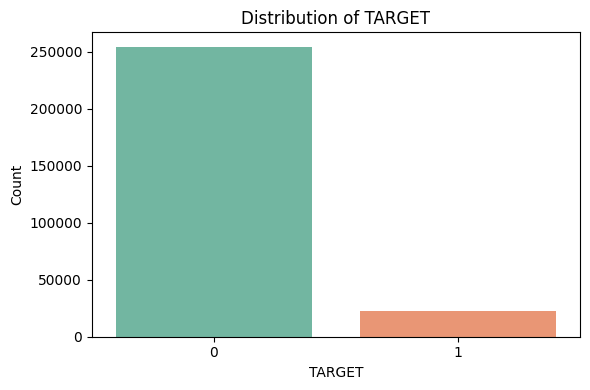

In [14]:
plot_target_distribution(inf_train_dropped, target_column="TARGET")

Below I have plotted how each variables squares up against the target variable. For the continuous variables, I have included both violin plots as well as bar plots with the average and their confidence intervals. Note that in doing so, I purposefully squeeze the titles of a few variables together, making it illegible. This is done simply for the purpose of gaining an overview, and as we care less about individual feature values and more about the general distribution, this is justified. As one can see...
- A few variables which have an imbalance of data. Some cases of nominal variables and a specific value have almost no observations. This is problematic. Consequently, we will later use balanced ML models to tackle this.
- Various continuous variables seem to have a very long tail. This could skew results. Consequently, I later cut variables to only include 99% of the main distribution to deal with potential anomalous data, and I then log transform the remaining values.

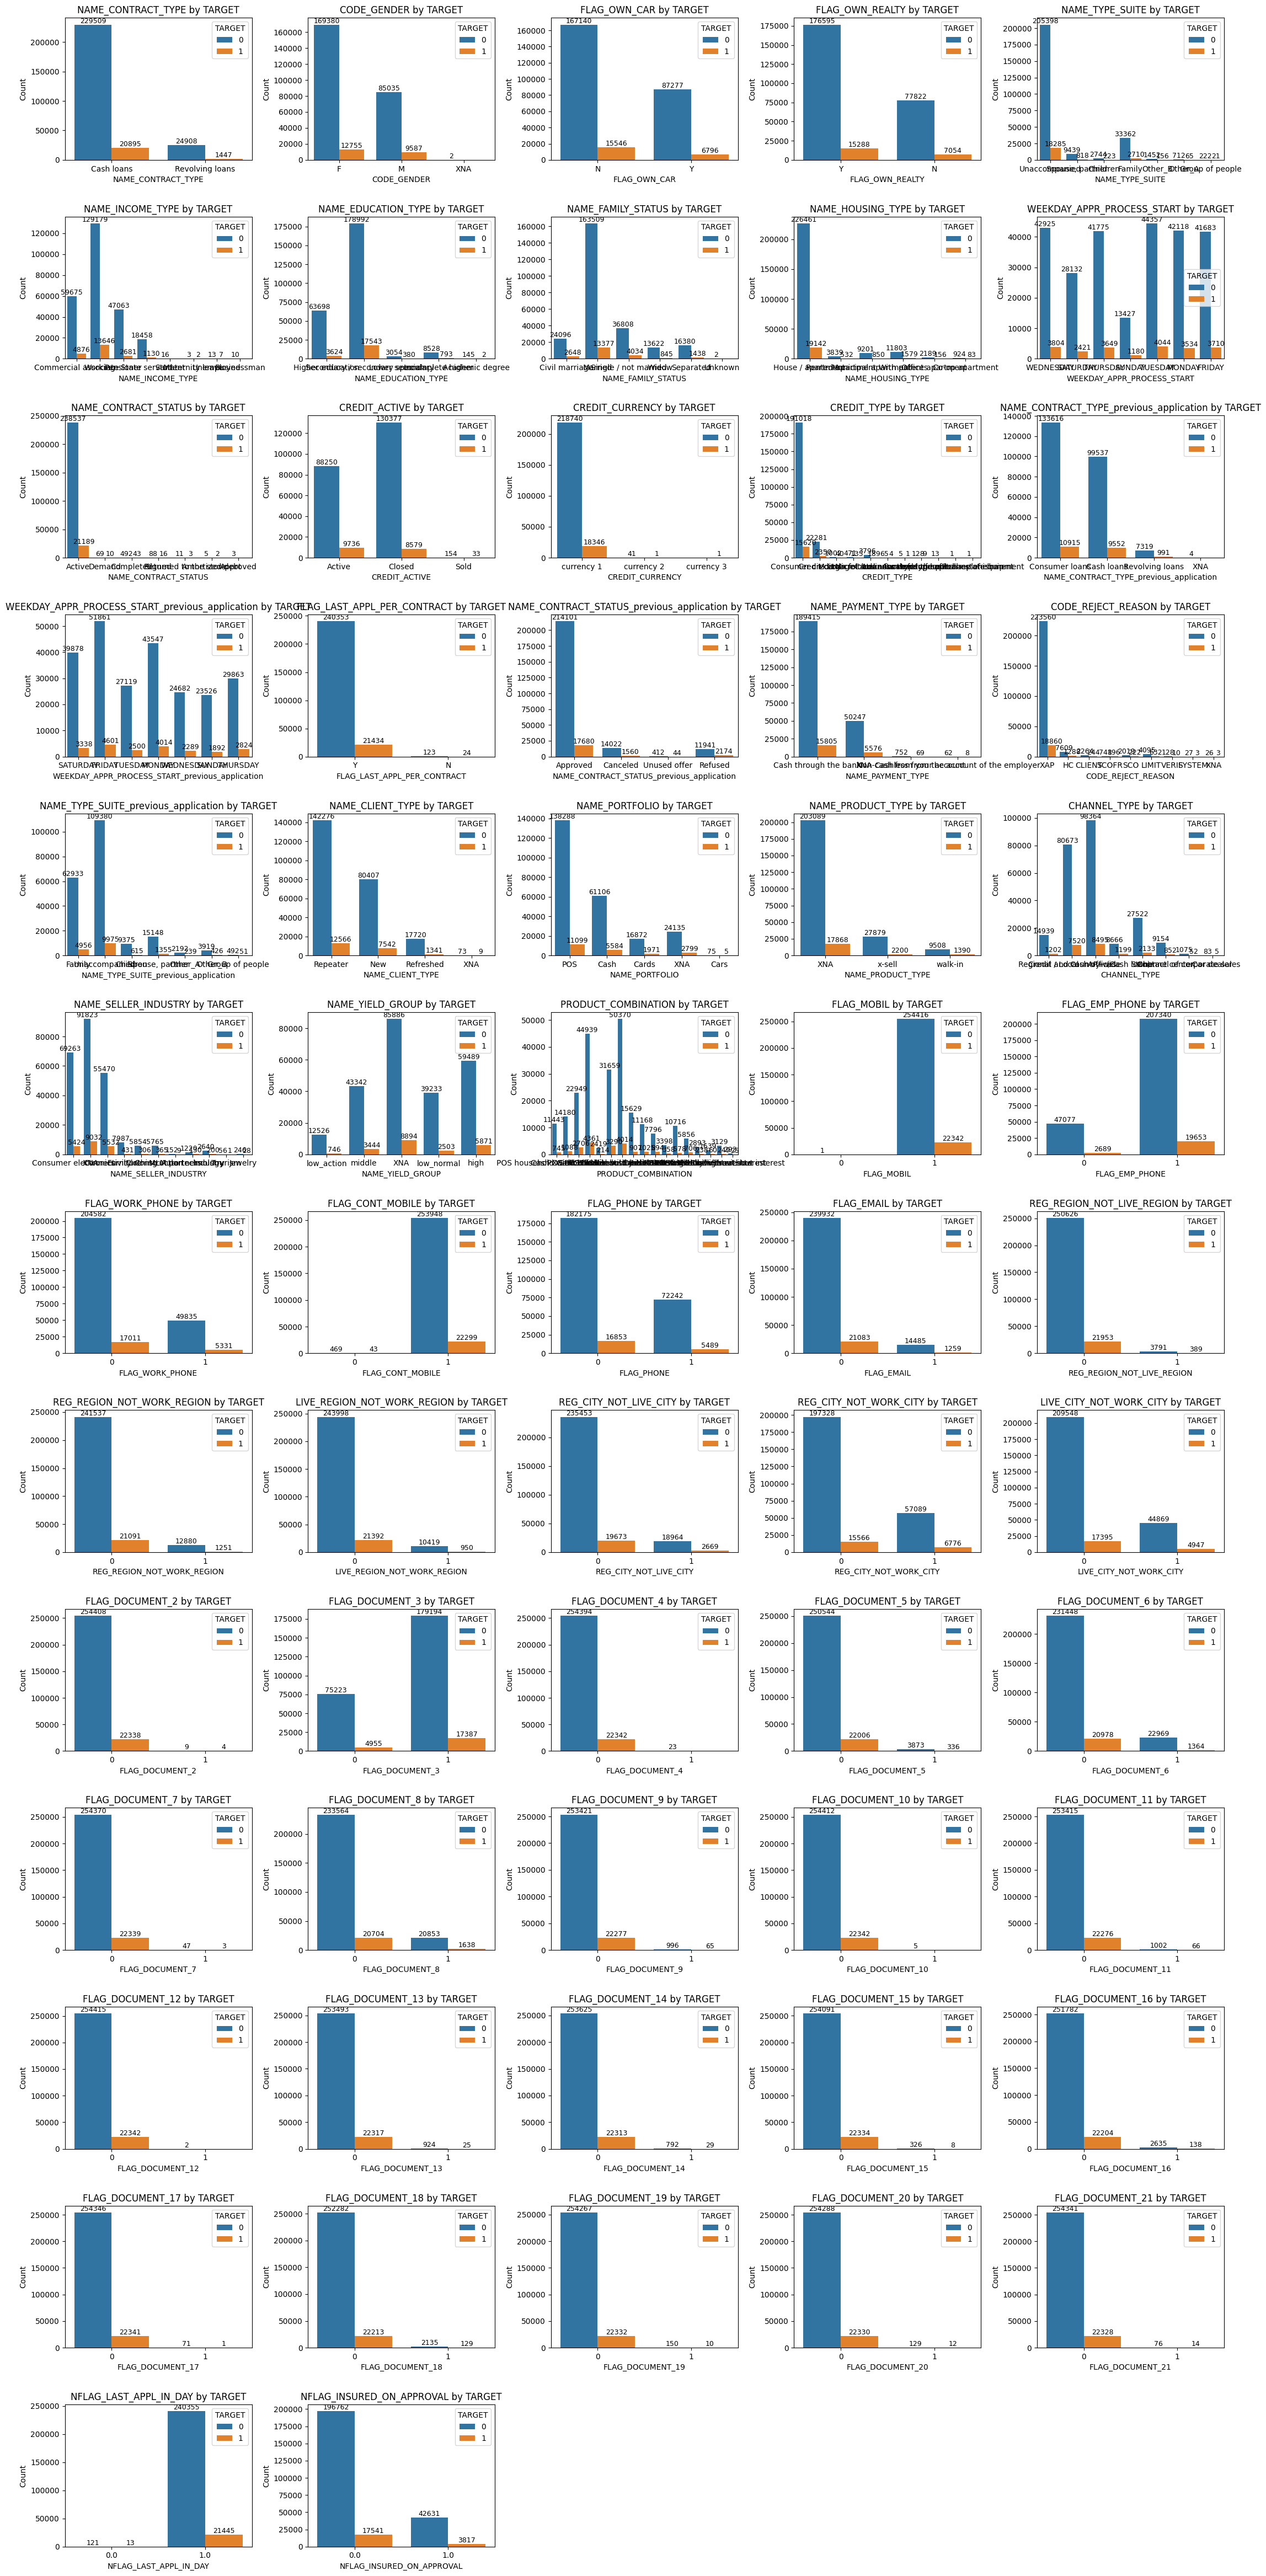

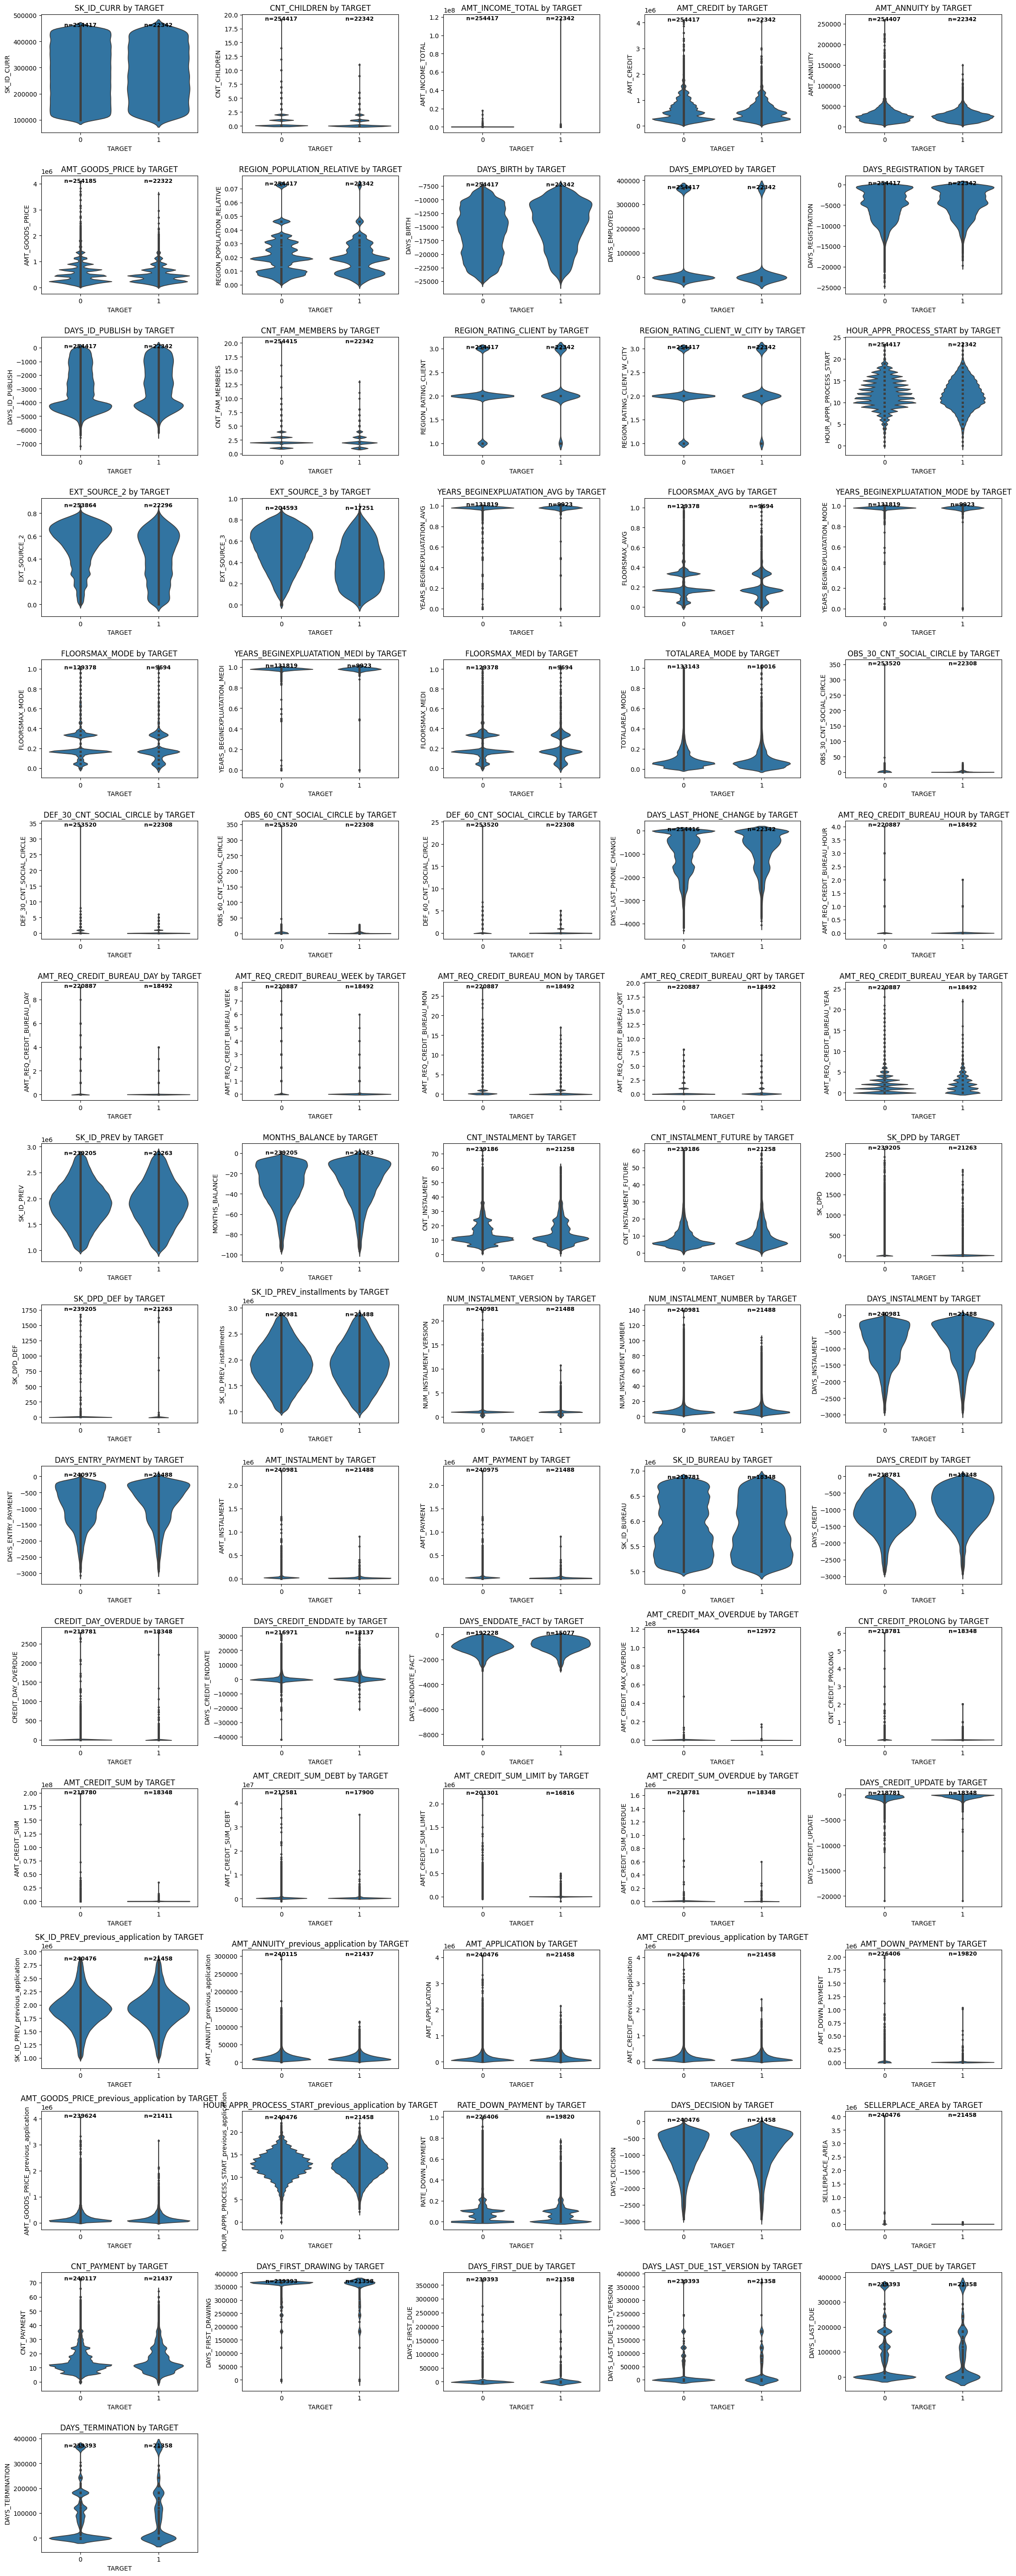

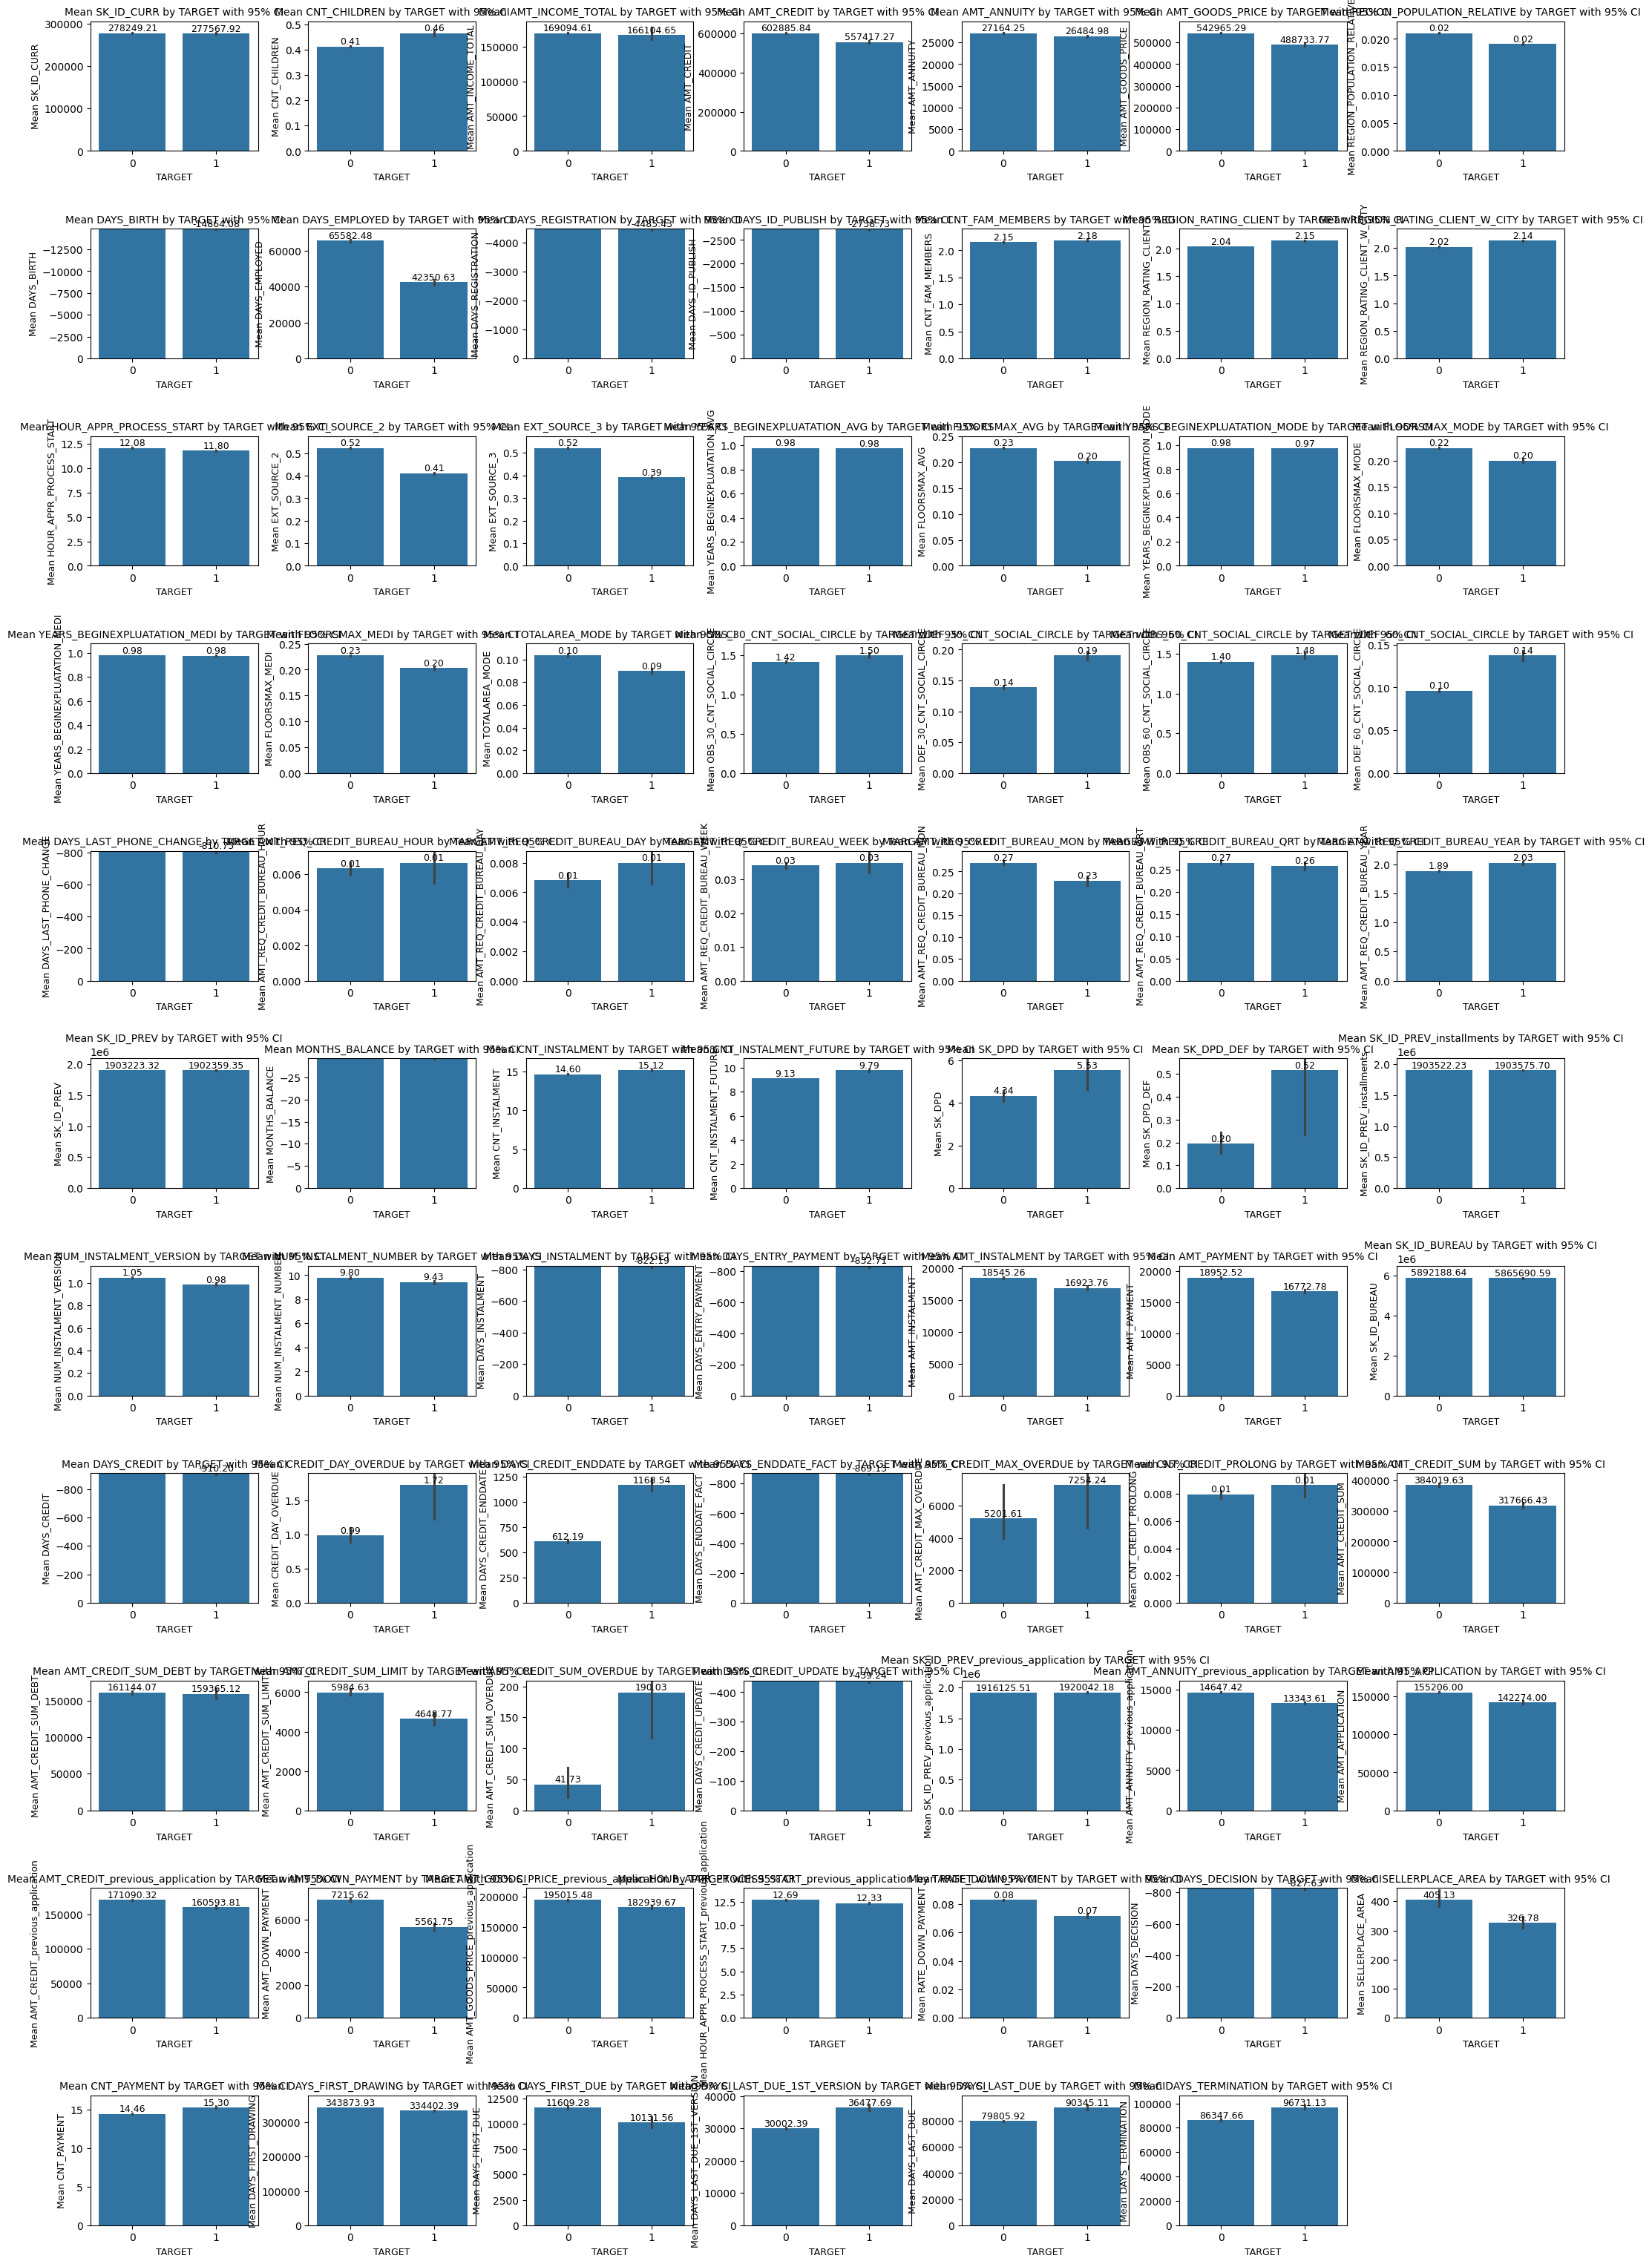

In [15]:
full_eda_visualization(inf_train_dropped, target_column="TARGET")

## Replacing Missing Values
As mentioned earlier, I initially set out to use KNN data imputation in cases of continuous numeric columns. However, the dataset is simply too large for my hardware, given how much computational power it requires. This was the case even though I used batching, with a relatively small number of data sizes per batching. Consequently, I have switched to another method. However, as this scenario would likely turn into a point where this model would be developed for clients, one might assume a correspondingly higher emphasis on compute. As such, I have still developed a function that uses KNN. Though, the benefits in this regard are typically minor with each added neighbor. However, in this case, I instead impute using the median value, which is less preferable, as it gives less valuable data by being less specific to the individual row. I also use the mode of the column in cases of non-numeric columns. Ideally, it would be preferable in the cases of non-numeric data, to use a method that leverages the philosophy of KNN not imputing identical values, but rather a value tailored to the surrounding data points. However, I use the mode here, as the limited computing power on my computer struggled with more advanced tools.

In [16]:
inf_train_imputed = impute_data_median_mode(inf_train_dropped)

print(f"There are {inf_train_imputed.isnull().sum().sum()} missing values")

There are 0 missing values


## Cutting Anomalous Outliers, Log Transforming, and Applying Robust Scaler

As mentioned, there are a variety of long tails in certain continuous variables. As such, I first winsorize them to be rid of potential anomalous outliers, and then I use RobustScaler to bring each variable to a similar unit of analysis, making it easier for the inferential analysis to analyze and compare them.

In [17]:
columns_description_df = pd.read_csv(
    "Data/HomeCredit_columns_description.csv",
    usecols=["Row", "Description"],
    encoding="latin1",
)

In [18]:
import math

In [19]:
inf_train_winsorize = winsorize_dataframe(inf_train_imputed)

In [20]:
# inspect_negative_value_distributions_with_descriptions(
#    inf_train_winsorize,
#    columns_description_df,
#    column_name_col="Row",
#    description_col="Description",
# )

In [21]:
inf_train_scaled = robust_scale_dataframe(inf_train_winsorize)

## One-Hot-Encoding and Converting Boolean Columns to Integers
Since there are a variety of nominal non-numeric columns which have numerous unique values, these need to be partitioned. As there are none that seem to have a natural ordering, I utilize one-hot-encoding. There are certain columns which have too high a number of unique values (e.g., 58). As such, one-hot-encoding these would introduce a lot more dimensionality, which would overly slow the code. Consequently, I drop columns with a cardinality higher than 15.
After this I also convert boolean figures which are not currently numeric (e.g., with 'False', and 'True' values) to numeric boolean figures ('0' and '1').

In [22]:
inf_train_encoded = encode_and_drop_high_cardinality(inf_train_scaled, max_unique=15)

🗑️ Dropping columns with > 15 unique values: ['ORGANIZATION_TYPE', 'NAME_CASH_LOAN_PURPOSE', 'NAME_GOODS_CATEGORY', 'PRODUCT_COMBINATION']
🔁 One-hot encoding columns: ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'NAME_CONTRACT_STATUS', 'CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'CREDIT_TYPE', 'NAME_CONTRACT_TYPE_previous_application', 'WEEKDAY_APPR_PROCESS_START_previous_application', 'FLAG_LAST_APPL_PER_CONTRACT', 'NAME_CONTRACT_STATUS_previous_application', 'NAME_PAYMENT_TYPE', 'CODE_REJECT_REASON', 'NAME_TYPE_SUITE_previous_application', 'NAME_CLIENT_TYPE', 'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE', 'CHANNEL_TYPE', 'NAME_SELLER_INDUSTRY', 'NAME_YIELD_GROUP']


In [23]:
inf_train_bool = convert_boolean_columns_to_int(inf_train_encoded)

## Checking Multicollinearity
Next, I check whether there are any variables that are correlated with each other. This could inflate our coefficients. In doing so, I first drop any columns which are constant, and thereafter drop all columns with a VIF higher than 5. In doing so, I receive a few warnings that some columns are dividing by zero, which can occur when having a (near)constant degree of values (this is fine, as the code drops these columns after). I also do this iteratively, as dropping one column might have an influence on the remaining columns.

In [24]:
inf_train_corr, dropped_corr_cols = drop_highly_correlated_features(
    inf_train_bool, target_col="TARGET", threshold=0.8
)
print("Dropped highly correlated columns:", dropped_corr_cols)

Dropped highly correlated columns: ['AMT_GOODS_PRICE', 'FLAG_EMP_PHONE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT_W_CITY', 'LIVE_REGION_NOT_WORK_REGION', 'LIVE_CITY_NOT_WORK_CITY', 'YEARS_BEGINEXPLUATATION_MODE', 'FLOORSMAX_MODE', 'YEARS_BEGINEXPLUATATION_MEDI', 'FLOORSMAX_MEDI', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'CNT_INSTALMENT_FUTURE', 'SK_ID_PREV_installments', 'DAYS_INSTALMENT', 'DAYS_ENTRY_PAYMENT', 'AMT_PAYMENT', 'DAYS_CREDIT_UPDATE', 'AMT_APPLICATION', 'AMT_CREDIT_previous_application', 'AMT_GOODS_PRICE_previous_application', 'DAYS_DECISION', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_TERMINATION', 'NAME_TYPE_SUITE_Unaccompanied', 'NAME_INCOME_TYPE_Pensioner', 'NAME_EDUCATION_TYPE_Secondary / secondary special', 'CREDIT_TYPE_Credit card', 'NAME_PORTFOLIO_POS']


In [25]:
vif_df, inf_train_VIF = calculate_vif_and_drop_high_vif_iterative(
    inf_train_corr,
    target_col="TARGET",
    sample_size=2000,
    large_sample_size=20000,
    random_state=42,
    vif_threshold=5,
    low_variance_threshold=1e-5,
)

print(vif_df)
print(f"Remaining columns: {inf_train_VIF.shape[1]}")
print(f"Does cleaned_df include target? {'TARGET' in inf_train_VIF.columns}")

Dropping low variance columns on full data before sampling: ['FLAG_MOBIL', 'FLAG_DOCUMENT_12', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'CREDIT_DAY_OVERDUE', 'AMT_CREDIT_SUM_OVERDUE', 'CODE_GENDER_XNA', 'NAME_FAMILY_STATUS_Unknown', 'CREDIT_CURRENCY_currency 3', 'CREDIT_TYPE_Loan for the purchase of equipment', 'CREDIT_TYPE_Real estate loan']
Dropping constant/low variance columns on sampled data: ['NAME_TYPE_SUITE_Group of people', 'CHANNEL_TYPE_Car dealer', 'NAME_SELLER_INDUSTRY_Tourism', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_10', 'NAME_INCOME_TYPE_Maternity leave', 'NAME_CONTRACT_STATUS_Amortized debt', 'CREDIT_TYPE_Loan for working capital replenishment', 'NAME_CLIENT_TYPE_XNA', 'CODE_REJECT_REASON_VERIF', 'FLAG_DOCUMENT_21', 'CREDIT_TYPE_Unknown type of loan', 'NAME_CONTRACT_STATUS_Approved', 'NAME_PORTFOLIO_Cars', 'CREDIT_CURRENCY_currency 2', 'NAME_INCOME_TYPE_Unemployed', 'NAME_PAYMENT_TYPE_Cashless from the account of the employer', 'FLAG_DOCU

# Running an Inferential Logistic Regression

In [26]:
model_sig, df_sampled = preprocess_and_fit_logit(inf_train_VIF, target_col="TARGET")


Summary of logistic regression model with significant variables only:
                           Logit Regression Results                           
Dep. Variable:                 TARGET   No. Observations:               100000
Model:                          Logit   Df Residuals:                    99965
Method:                           MLE   Df Model:                           34
Date:                Tue, 08 Jul 2025   Pseudo R-squ.:                  0.1004
Time:                        01:59:52   Log-Likelihood:                -25238.
converged:                       True   LL-Null:                       -28055.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                   coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
Intercept                                       -2.7971      0.027   -1

The logistic regression model was statistically significant overall, as indicated by a Likelihood Ratio Test p-value < 0.001. The McFadden’s Pseudo R² of 0.1004 suggests the model explains about 10.0% of the variance in the target variable.

Below are the ten strongest calibrated variables from the model, with coefficients (β) and p-values:

**SK_DPD_DEF (β = 0.7830, p < 0.001)**. Default status strongly increases the log odds of the event.

**EXT_SOURCE_2 (β = -0.6198, p < 0.001)**. Higher scores on this external source reduce the odds significantly.

**EXT_SOURCE_3 (β = -0.5384, p < 0.001)**. Similarly, better scores here decrease odds.

**AMT_ANNUITY (β = 0.3216, p < 0.001)**. Larger annuity payments increase the likelihood.

**CNT_PAYMENT (β = 0.2601, p < 0.001)**. More payments are associated with higher odds.

**DAYS_BIRTH (β = 0.2031, p < 0.001)**. Older individuals have higher odds.

**AMT_CREDIT (β = -0.2050, p < 0.001)**. Higher credit amounts reduce the odds.

**AMT_ANNUITY_previous_application (β = -0.1495, p < 0.001)**. Larger previous annuities decrease the odds.

**SK_DPD (β = 0.0722, p = 0.005)**. More days past due slightly increase odds.

**CNT_CHILDREN (β = -0.0458, p = 0.015)**. More children slightly reduce the odds.


## Checking Assumptions
Next I quickly check the assumptions of the model to ensure that these results warrant trust. I only lightly test these assumptions, as the main focus of this analysis is the machine learning algorithms

## Multicollinearity
Upheld. This was ensured by removing constant and near-constant variables, as well as any variables that had a higher VIF than 5. 

## Adequately Large Sample Size
As discussed earlier, there are several groups that are quite low in sample size. This is worsened even more when considering how the logistic regression only took a sample of this. As such, this assumption is likely violated.

## No Outliers
As seen earlier in the boxplot, there were outliers, as well as skewed distribution.. However, I used winsorization and robust scaler to lessen the influence of these on the data.

## Linear Logit Functions

In [27]:
check_linear_logit_assumption(model_sig, df_sampled, target_col="TARGET")

Variables passing linear logit assumption: 9
Variables failing linear logit assumption: 25


## Independent Observations
From our perspective, we can assume the independence of observations, as they ostensibly would be so. However, as we are not familiar with how the data was sampled, we cannot speak too confidently to this point.

# Building Machine Learning Models
Next I build a variety of machine learning algorithms to try and predict whether a customer will have a default or not. In choosing what evaluation metric to work by, I reconsider the assumptions I made earlier about our potential clients:
- Above all, banks seek to reduce the number of defaults on loans
- Different banks assess risk differently, and may take different metrics into consideration.
- Banks generally appreciate an interpretable and transparent model, though this is of lesser concern compared to other industries (e.g., medicine), with more emphasis being placed on the previous points.

Because I specifically assume that different banks would assess a predictive model through different lenses, any solution for specific clients would have to be tailored further. For this demonstration, I choose to focus more on the **positive** cases of defaults (i.e., people **actually** defaulting as opposed to not), as I assume this demographic to be what costs banks money at the end of the day. In this positive case, I also assume that banks would be most interested in building a model that captures all the people who **might** default. Consequently, I arrive at **recall** as being a figure of central importance. This is perhaps also the most important, considering how many banks take into account a wide array of factors in giving a loan, and that it often requires the assessment of human eyes on an ad-hoc basis.

## Preprocessing pipeline
First I build a pipeline that makes sure to treat the data in a way similar to what I did earlier with the inferential regression.
Specifically, it:

1. Identifies and drops all columns with more than 50% of missing data, as well as non-numeric or binary (i.e., only two unique values in feature) columns that simply have more than 30% of missing data.
2. Uses data imputation to replace values. Specifically, the mode is used to replace missing values in non-numeric or binary features, and the median is used to replace missing values in numeric features
3. Cuts anomalous outliers from continuous variable by using a 95% winsorization.
5. One-hot-encodes all non-numeric and binary columns.
6. Transforms all binary columns to '0's and '1's, and ensure that we now only have numeric columns in the dataset.
7. Applies RobustScaler to continuous variables
8. Drops all features which have no or almost no variance.
9. Finds and drops all features which have a correlation higher than 0.80.
10. Investigate the VIF, based on sample sizes of 5000, to see which features have a score higher than 4. These are dropped from the dataset. This is not done iteratively, as this would take up too much compute. Note that this is only a minimum viable product, and if deployed to

However, in this process, I do not check VIF or other measures of multicollinearity. The reason that I do not due this is simply due to computational power. I attempted to do this under various circumstances, such as in the inferential logistic regression prior to this. However, in all circumstances, it ended up taking an excessive amount of time which my personal (and old) computer could not process. For similar reasons, I also do not perform hyperparameter tuning. This was despite a variety of methods having been tried, like Optuna, RandomizedSearch, Gridsearch, and Coarse-to-fine (and also on subsets of data), which all were either exceedingly slow, or made my computer break down. However, as this is only a minimum viable product, with a real-life scenario involving more computational power, either through owned cores and processors or in the cloud, this is accepted here. As such, the models will most likely always underperform compared to what they might achieve with hyperparameter tuning. Likewise, I only run learning curves for some of the data, as it at times is either too costly, or does not fit the model inherently.

In [28]:
def build_pipeline(X):
    """
    Given a DataFrame X, returns:
      - full_pipeline: Pipeline(dropper → ColumnTransformer)
      - cont_cols, cat_cols, bin_cols: the lists of column names
    """
    preprocessor = DataPreprocessor()
    preprocessor.fit(X)
    cont_cols, cat_cols, bin_cols = preprocessor.get_feature_names()

    cont_pipeline = Pipeline(
        [
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", RobustScaler()),
            ("winsor", Winsorizer()),
            ("clip", TailClipper()),
        ]
    )

    cat_pipeline = Pipeline(
        [
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore", drop="if_binary")),
        ]
    )

    bin_pipeline = Pipeline(
        [
            ("imputer", SimpleImputer(strategy="most_frequent")),
        ]
    )

    column_transformer = ColumnTransformer(
        [
            ("cont", cont_pipeline, cont_cols),
            ("cat", cat_pipeline, cat_cols),
            ("bin", bin_pipeline, bin_cols),
        ]
    )

    full_pipeline = Pipeline(
        [
            ("dropper", preprocessor),
            ("transform", column_transformer),
        ]
    )

    return full_pipeline, cont_cols, cat_cols, bin_cols

## Comparing to a Dummy Classifier

In [29]:
dummy_strat = DummyClassifier(strategy="stratified", random_state=42)
dummy_strat.fit(X_train, y_train)
y_strat_pred = dummy_strat.predict(X_test)
y_strat_proba = dummy_strat.predict_proba(X_test)[:, 1]

print("\nDummy Classifier (stratified):")
print(classification_report(y_test, y_strat_pred))
print(f"Test AUC: {roc_auc_score(y_test, y_strat_proba):.3f}")
print(f"Test Accuracy: {accuracy_score(y_test, y_strat_pred):.3f}")


Dummy Classifier (stratified):
              precision    recall  f1-score   support

           0       0.92      0.92      0.92     28269
           1       0.07      0.07      0.07      2483

    accuracy                           0.85     30752
   macro avg       0.50      0.50      0.50     30752
weighted avg       0.85      0.85      0.85     30752

Test AUC: 0.496
Test Accuracy: 0.851


## Base Model: Logistic Regression
As a base model, I choose to employ a Logistic Regression. This is as it is a relatively simple ML model that is also often competitive with other models. As can be seen, below, this ends up with a recall of the positive case around 0.68, with the precision following much further behind at only 0.16. Altogether, this does not provide a ton of value, given the large tradeoff in precision that we are making here in favor of recall (i.e., by using a balanced scale weight). However, this is of course prior to hyperparameter tuning, which, as mentioned, I do not perform here.

As can also be seen, the learning curve shows a general convergence of the training and validation scores, which is good, as it indicates that we are not overfitting.
Also, the Shapley values indicates the five most decisive features to be:
1. EXT_SOURCE_2
2. EXT_SOURCE_3
3. AMT_ANNUITY
4. DAYS_FIRST_DRAWING
5. CNT_INSTALMENT_FUTURE

In [30]:
full_pipeline, cont_cols, cat_cols, bin_cols = build_pipeline(X_train)

results_df = pd.DataFrame(
    columns=[
        "model",
        "precision_0",
        "recal_0",
        "f1_0",
        "precision_1",
        "recall_1",
        "f1_1",
    ]
)

C:\Users\david\anaconda3\Lib\site-packages\numpy\lib\_function_base_impl.py:4842: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(



Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.70      0.81     28269
           1       0.16      0.68      0.26      2483

    accuracy                           0.69     30752
   macro avg       0.56      0.69      0.54     30752
weighted avg       0.90      0.69      0.76     30752


Test AUC: 0.757
Test Accuracy: 0.694


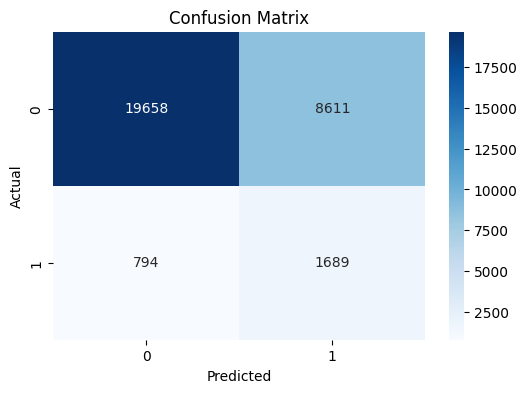

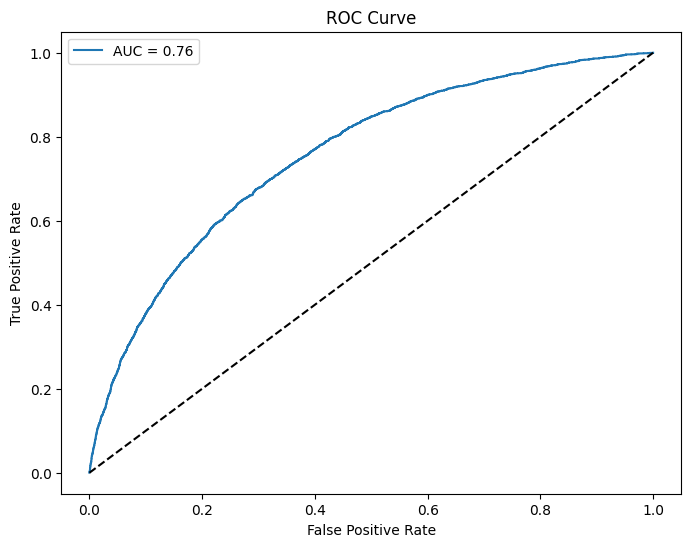

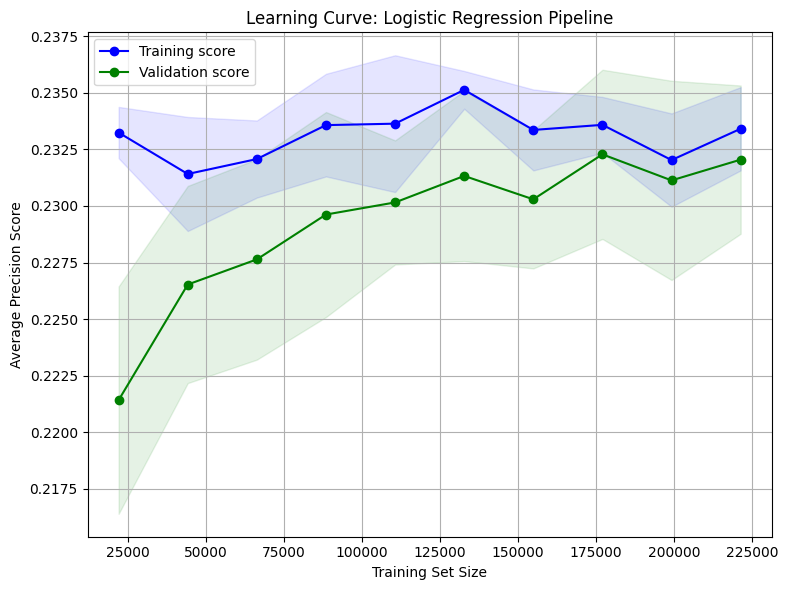

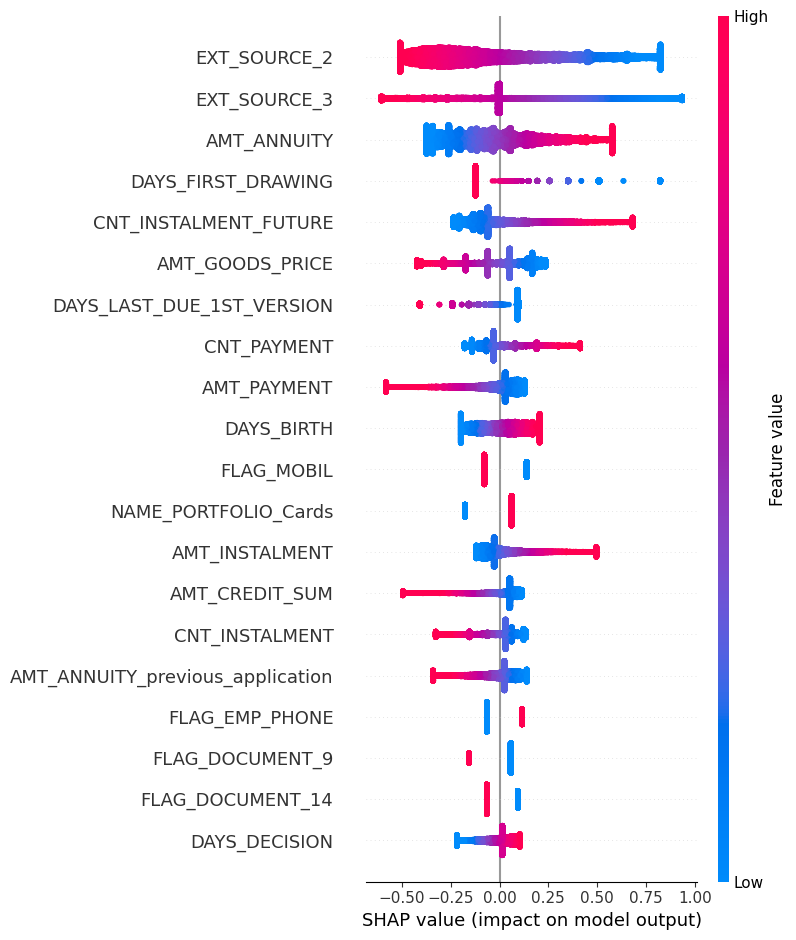

In [31]:
default_clf = LogisticRegression(
    C=1,
    penalty="l2",
    solver="liblinear",
    class_weight="balanced",
    max_iter=1000,
    random_state=42,
)

final_pipeline = Pipeline(
    [
        ("preprocessor", full_pipeline),
        ("classifier", default_clf),
    ]
)

final_pipeline.fit(X_train, y_train)

y_pred = final_pipeline.predict(X_test)
y_proba = final_pipeline.predict_proba(X_test)[:, 1]

evaluate_model_performance(y_test, y_pred, y_proba)

plot_learning_curve(
    model=final_pipeline,
    X=X_train,
    y=y_train,
    scoring="average_precision",
    cv=5,
    title="Learning Curve: Logistic Regression Pipeline",
)

results_df = append_class_metrics(y_test, y_pred, final_pipeline, results_df=results_df)

cont_cols, cat_cols, bin_cols = (
    final_pipeline.named_steps["preprocessor"]
    .named_steps["dropper"]
    .get_feature_names()
)

feature_names = get_feature_names(final_pipeline, cont_cols, cat_cols, bin_cols)

X_test_preprocessed = (
    final_pipeline.named_steps["preprocessor"]
    .named_steps["transform"]
    .transform(X_test)
)

if hasattr(X_test_preprocessed, "toarray"):
    X_test_preprocessed = X_test_preprocessed.toarray()

explainer = shap.LinearExplainer(
    final_pipeline.named_steps["classifier"], X_test_preprocessed
)
shap_values = explainer.shap_values(X_test_preprocessed)

shap.summary_plot(shap_values, X_test_preprocessed, feature_names=feature_names)

## Comparing Other Basic Models
Next I compare a variety of other models, such as a Support Vector Classifier, a Naive Bayes, an XGBoost, a LightGBM, and a BalancedRandomForest. I use a LinearSVC, with CalibratedClassifierCV to get the probabilities of prediction, instead of the normal SVC from sklearn. I do this given the extremely large data size, which makes the SVC take between 10x and 100x faster to run. Given my limited compute, this is best I can do. Regardless, it shows a similar indication of value, with potential customers being able to consider the more typical SVC (with linear, rbf, and more advanced options for the kernel). Here I only focus on the metrics that are of most importance to us, which we can see below in the table.
As can be seen, it appears that the logistic regression, LightGBM, and XGBoost are the highest performers, with both having a recall around 0.69. This is not too high, though one must remember that this is prior to any hyperparameter tuning, which can have significant increases in performance (e.g., increase of 0.10). 

In [32]:
counter = Counter(y_train)
neg, pos = counter[0], counter[1]
scale_pos_weight = neg / pos

models = {
    "NaiveBayes": GaussianNB(),
    "XGBoost": XGBClassifier(
        n_estimators=100,
        max_depth=4,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.5,
        reg_lambda=1,
        eval_metric="logloss",
        scale_pos_weight=scale_pos_weight,
        use_label_encoder=False,
        random_state=42,
        n_jobs=-1,
    ),
    "LightGBM": LGBMClassifier(
        n_estimators=100,
        max_depth=4,
        learning_rate=0.1,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        class_weight="balanced",
        reg_alpha=0.5,
        reg_lambda=1,
        random_state=42,
        n_jobs=-1,
    ),
    "BalancedRandomForest": BalancedRandomForestClassifier(
        n_estimators=100,
        max_depth=5,
        random_state=42,
        n_jobs=-1,
    ),
    "LinearSVC": CalibratedClassifierCV(
        estimator=LinearSVC(
            class_weight="balanced",
            C=0.5,
            max_iter=10000,
            random_state=42,
        ),
        method="sigmoid",
        cv=3,
    ),
    "CatBoost": CatBoostClassifier(
        iterations=100,
        learning_rate=0.1,
        depth=4,
        l2_leaf_reg=3.0,
        scale_pos_weight=scale_pos_weight,
        verbose=0,
        random_seed=42,
    ),
    "MLP": MLPClassifier(
        hidden_layer_sizes=(100,),
        alpha=0.01,
        max_iter=200,
        early_stopping=True,
        random_state=42,
    ),
}

for model_name, model in models.items():
    start_time = time.time()

    full_pipeline, cont_cols, cat_cols, bin_cols = build_pipeline(X_train)

    X_train_proc = full_pipeline.fit_transform(X_train)
    X_test_proc = full_pipeline.transform(X_test)

    model.fit(X_train_proc, y_train)

    y_pred = model.predict(X_test_proc)
    y_proba = model.predict_proba(X_test_proc)[:, 1]

    results_df = append_class_metrics(y_test, y_pred, model, results_df=results_df)

    print(f"{model_name} trained in {time.time() - start_time:.2f} seconds.")

C:\Users\david\anaconda3\Lib\site-packages\numpy\lib\_function_base_impl.py:4842: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


NaiveBayes trained in 50.63 seconds.


C:\Users\david\anaconda3\Lib\site-packages\numpy\lib\_function_base_impl.py:4842: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Users\david\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [02:17:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost trained in 74.67 seconds.


C:\Users\david\anaconda3\Lib\site-packages\numpy\lib\_function_base_impl.py:4842: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


[LightGBM] [Info] Number of positive: 22342, number of negative: 254417
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.177966 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13708
[LightGBM] [Info] Number of data points in the train set: 276759, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

C:\Users\david\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\david\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


LightGBM trained in 50.24 seconds.


C:\Users\david\anaconda3\Lib\site-packages\numpy\lib\_function_base_impl.py:4842: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


BalancedRandomForest trained in 57.14 seconds.


C:\Users\david\anaconda3\Lib\site-packages\numpy\lib\_function_base_impl.py:4842: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


LinearSVC trained in 103.31 seconds.


C:\Users\david\anaconda3\Lib\site-packages\numpy\lib\_function_base_impl.py:4842: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


CatBoost trained in 100.80 seconds.


C:\Users\david\anaconda3\Lib\site-packages\numpy\lib\_function_base_impl.py:4842: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


MLP trained in 418.99 seconds.


In [33]:
results_df

model  precision_0  recall_0      f1_0  \
0              LogisticRegression     0.961177  0.695391  0.806962   
1                      GaussianNB     0.925129  0.960310  0.942391   
2                   XGBClassifier     0.963409  0.704128  0.813611   
3                  LGBMClassifier     0.962813  0.707984  0.815965   
4  BalancedRandomForestClassifier     0.958165  0.679755  0.795298   
5          CalibratedClassifierCV     0.920143  0.998620  0.957777   
6              CatBoostClassifier     0.962510  0.702041  0.811897   
7                   MLPClassifier     0.919853  0.999151  0.957864   

   precision_1  recall_1      f1_1  
0     0.163981  0.680226  0.264257  
1     0.203125  0.115183  0.147006  
2     0.171143  0.695530  0.274694  
3     0.171601  0.688683  0.274743  
4     0.153688  0.662102  0.249469  
5     0.458333  0.013290  0.025832  
6     0.168756  0.688683  0.271084  
7     0.478261  0.008860  0.017398

# Ensemble Models
Next, I try a variety of different ensemble models.

## Voting Model Based on Best Performers
Next I synthesize the three highest performers in recall (logistic regression, LightGBM, XGBoost) together to build a soft voting model. As can be seen in the table below, the results are only marginally better than each model individually, though still the most preferable so far.

In [34]:
logistic = LogisticRegression(
    C=1,
    penalty="l2",
    solver="liblinear",
    class_weight="balanced",
    max_iter=1000,
    random_state=42,
)

lgbm = LGBMClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1,
)

xgb = XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.5,
    reg_lambda=1,
    eval_metric="logloss",
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1,
)

voting_clf = VotingClassifier(
    estimators=[
        ("lr", logistic),
        ("lgbm", lgbm),
        ("xgb", xgb),
    ],
    voting="soft",
)

pipeline = Pipeline(
    [
        ("preprocessor", full_pipeline),
        ("classifier", voting_clf),
    ]
)

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]
print("Voting Model (LR + LGBM + XGB) Fitted")

results_df = append_class_metrics(y_test, y_pred, pipeline, results_df=results_df)

C:\Users\david\anaconda3\Lib\site-packages\numpy\lib\_function_base_impl.py:4842: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


[LightGBM] [Info] Number of positive: 22342, number of negative: 254417
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.211009 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13708
[LightGBM] [Info] Number of data points in the train set: 276759, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

C:\Users\david\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [02:31:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\david\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Voting Model (LR + LGBM + XGB) Fitted


C:\Users\david\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [35]:
results_df

model  precision_0  recall_0      f1_0  \
0              LogisticRegression     0.961177  0.695391  0.806962   
1                      GaussianNB     0.925129  0.960310  0.942391   
2                   XGBClassifier     0.963409  0.704128  0.813611   
3                  LGBMClassifier     0.962813  0.707984  0.815965   
4  BalancedRandomForestClassifier     0.958165  0.679755  0.795298   
5          CalibratedClassifierCV     0.920143  0.998620  0.957777   
6              CatBoostClassifier     0.962510  0.702041  0.811897   
7                   MLPClassifier     0.919853  0.999151  0.957864   
8                VotingClassifier     0.963201  0.706463  0.815093   

   precision_1  recall_1      f1_1  
0     0.163981  0.680226  0.264257  
1     0.203125  0.115183  0.147006  
2     0.171143  0.695530  0.274694  
3     0.171601  0.688683  0.274743  
4     0.153688  0.662102  0.249469  
5     0.458333  0.013290  0.025832  
6     0.168756  0.688683  0.271084  
7     0.478261  0.008860  0.017398  
8     0.171691  0.692710  0.275178

## Layered Voting Model Based on Best Performer
Next I take the single best model, and use bagging by training different iterations of the model on the same positive case data (i.e., a default) but completely different batches of negative case data (i.e., no default). This gets around the issue of the dataset being imbalanced. As can be seen, we also end up with an extremely high recall (around 0.99) which seems slightly dubious. However, given the emphasis we end up placing on the positive case by reutilizing this data across so many of the models, this gives some sense. We see the cost in the precision of the positive case, which ends up being around only 0.08. As such, it might in practice give a lot of confidence in relation to being able to capture positive cases, yet the very low precision would likely also prove a significant practical burden. We must keep in mind, however, the lack of hyperparameter tuning.

In [42]:
class BalancedBaggingClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, preprocessor, base_estimator, random_state=None):
        """
        preprocessor    : a fitted Pipeline/Transformer (dropper→ColumnTransformer)
        base_estimator  : an unfitted classifier instance (e.g. LogisticRegression())
        """
        self.preprocessor = preprocessor
        self.base_estimator = base_estimator
        self.random_state = random_state

    def fit(self, X, y):
        # 1) make sure X is a DataFrame
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        y = pd.Series(y, index=X.index)

        # 2) fit the preprocessor once on all data
        self.preprocessor_ = clone(self.preprocessor)
        self.preprocessor_.fit(X, y)
        # transform the *entire* train set once
        X_all = self.preprocessor_.transform(X)

        # 3) find positive / negative indices
        pos_idx = np.flatnonzero(y.values == 1)
        neg_idx = np.flatnonzero(y.values == 0)

        P = len(pos_idx)
        N = len(neg_idx)
        n_models = N // P

        # 4) shuffle & chunk negatives
        rng = np.random.default_rng(self.random_state)
        rng.shuffle(neg_idx)
        neg_chunks = np.array_split(neg_idx, n_models)

        # 5) for each chunk build & fit one classifier
        self.estimators_ = []
        for chunk in neg_chunks:
            idx = np.concatenate([pos_idx, chunk])
            Xb = X_all[idx]
            yb = y.values[idx]

            est = clone(self.base_estimator)
            est.fit(Xb, yb)
            self.estimators_.append(est)

        return self

    def predict_proba(self, X):
        # apply the *same* preprocessor
        Xp = self.preprocessor_.transform(X)
        # collect all the per‐estimator proba[:,1]
        probs = np.stack([m.predict_proba(Xp)[:, 1] for m in self.estimators_], axis=1)
        # average them
        mean_pos = probs.mean(axis=1)
        return np.vstack([1 - mean_pos, mean_pos]).T

    def predict(self, X):
        return (self.predict_proba(X)[:, 1] >= 0.5).astype(int)

In [43]:
full_pipeline, cont_cols, cat_cols, bin_cols = build_pipeline(X_train)

base_xgb = xgb = XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.5,
    reg_lambda=1,
    eval_metric="logloss",
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1,
)

layered_LR = BalancedBaggingClassifier(
    preprocessor=full_pipeline, base_estimator=base_xgb, random_state=42
)

layered_LR.fit(X_train, y_train)
y_pred = layered_LR.predict(X_test)
y_proba = layered_LR.predict_proba(X_test)[:, 1]

results_df = append_class_metrics(y_test, y_pred, layered_LR, results_df=results_df)

C:\Users\david\anaconda3\Lib\site-packages\numpy\lib\_function_base_impl.py:4842: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Users\david\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [02:41:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\david\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [02:41:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\david\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [02:41:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\david\anaconda3\Lib\site-packages\xgboost\tr

In [ ]:
results_df

## Stacked Model based on Best Performers


In [41]:
logistic = LogisticRegression(
    C=1,
    penalty="l2",
    solver="liblinear",
    class_weight="balanced",
    max_iter=1000,
    random_state=42,
)

lgbm = LGBMClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1,
)

xgb = XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.5,
    reg_lambda=1,
    eval_metric="logloss",
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1,
)

final_estimator = LogisticRegression(
    C=1,
    penalty="l2",
    solver="liblinear",
    class_weight="balanced",
    max_iter=1000,
    random_state=42,
)

stacking_clf = StackingClassifier(
    estimators=[
        ("lr", logistic),
        ("lgbm", lgbm),
        ("xgb", xgb),
    ],
    final_estimator=final_estimator,
    cv=5,  # 5-fold CV to train the meta-model (you can adjust)
    passthrough=False,  # False means only predictions of base estimators go to meta-model
    n_jobs=-1,
    verbose=1,
)

pipeline = Pipeline(
    [
        ("preprocessor", full_pipeline),
        ("classifier", stacking_clf),
    ]
)

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]

print("Stacking Model (LR + LGBM + XGB) Fitted")

results_df = append_class_metrics(y_test, y_pred, pipeline, results_df=results_df)

C:\Users\david\anaconda3\Lib\site-packages\numpy\lib\_function_base_impl.py:4842: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Users\david\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Stacking Model (LR + LGBM + XGB) Fitted


C:\Users\david\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [39]:
results_df

model  precision_0  recall_0      f1_0  \
0              LogisticRegression     0.961177  0.695391  0.806962   
1                      GaussianNB     0.925129  0.960310  0.942391   
2                   XGBClassifier     0.963409  0.704128  0.813611   
3                  LGBMClassifier     0.962813  0.707984  0.815965   
4  BalancedRandomForestClassifier     0.958165  0.679755  0.795298   
5          CalibratedClassifierCV     0.920143  0.998620  0.957777   
6              CatBoostClassifier     0.962510  0.702041  0.811897   
7                   MLPClassifier     0.919853  0.999151  0.957864   
8                VotingClassifier     0.963201  0.706463  0.815093   

   precision_1  recall_1      f1_1  
0     0.163981  0.680226  0.264257  
1     0.203125  0.115183  0.147006  
2     0.171143  0.695530  0.274694  
3     0.171601  0.688683  0.274743  
4     0.153688  0.662102  0.249469  
5     0.458333  0.013290  0.025832  
6     0.168756  0.688683  0.271084  
7     0.478261  0.008860  0.017398  
8     0.171691  0.692710  0.275178

# Final Comparison
As can be seen in the table above, numerous models perform relatively similar. Regardless, due to the nature of the scenario, I believe we can determine the three most interesting types of models: 
1. **Logistic Regression (base model)** (recall_1 = 0.68, f1_1 = 0.264, f1_0 = 0.80). While not being very sophisticated, this model holds up quite well in comparison to others. While the voting and stacking classifiers are the only two that beat the logistic regression on all measures (recall of the positive case, f1 of the positive case, as well as the f1 of the negative case), one must also notice that the logistic regression will likely be the consistently fastest model, requiring the least compute - which may matter at scale. Furthermore, it is also more interpretable than the other two models
2. **Voting Classifier** (recall_1 = 0.69, f1_1 = 0.28, f1_0 = 0.82) and **Stacking Classifier** (recall_1 = 0.70, f1_1 = 0.27, f1_0 = 0.81). As mentioned, these two models perform the best overall, when taking into account not just the recall of the positive case, but also the results of other metrics. Of these two, one could perhaps claim the voting model to hold some slight superiority, as it is a faster model.
3. **Balanced Bagging Classifier** (recall_1 = 0.99, f1_1 = 0.15, f1_0 = 0.04). This model has an incredibly high recall, which from a numerical standpoint makes sense, as we exposed so many logistic regression to the same positive dataset. However, this also comes with a risk of overfitting to this specific data, and in general, one should also be skeptical of such incredibly high evaluation metrics. Furthermore, the cost of this can also be seen in the shockingly low precision of the positive case, as well as the recall of the negative case.

In general, all models struggle significantly with precision. While regretful, this trade-off is also expected, as the purpose of this analysis was to maximize the case of recall in the positive sense. This will regularly be the case with such imbalanced datasets, and was done here under the assumption that recall of the positive case was the most important.

# Deployment
In deploying a model, I ultimately choose to deploy the voting classifier, as it seems the most appealing. Furthermore, the following deployment is more a proof-of-concept, and any potential client could and would of course naturally choose and tailor their own ideal model.
In deploying, I use joblib to dump the model, docker to containerize it, and Render to store the model in. A separate test file in this directory (test_api.py) has been created to showcase this deployment.

In [ ]:
full_pipeline, cont_cols, cat_cols, bin_cols = build_pipeline(X_train)

counter = Counter(y_train)
neg, pos = counter[0], counter[1]
scale_pos_weight = neg / pos

logistic = LogisticRegression(
    C=1,
    penalty="l2",
    solver="liblinear",
    class_weight="balanced",
    max_iter=1000,
    random_state=42,
)

lgbm = LGBMClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1,
)

xgb = XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.5,
    reg_lambda=1,
    eval_metric="logloss",
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1,
)

voting_clf = VotingClassifier(
    estimators=[
        ("lr", logistic),
        ("lgbm", lgbm),
        ("xgb", xgb),
    ],
    voting="soft",
)

pipeline = Pipeline(
    [
        ("preprocessor", full_pipeline),
        ("classifier", voting_clf),
    ]
)

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]
print("Voting Model (LR + LGBM + XGB) Fitted")

In [ ]:
joblib.dump(pipeline, "voting_model_pipeline.pkl")

# Conclusion
This analysis sought to understand and predict defaults on banks loans. In doing so, it firstly ran an inferential study to identify significant factors, where the ten most significant variables were identiifed. In this effort, data was first explored through an exploratory data analysis, whereafter it was cleaned and  structured to be ready for a logistic regression. This found a variety of different factors to be significant, though it should be mentioned that a few assumptions of the model were violated. While steps could be taken to remedy this potentially, this analysis went past this to place more emphasis on predicting defaults, as this was the chief aim of the analysis altogether. In doing this, it built and compared a range of different machine learning models to try to maximize the recall of the positive case, and thereafter the f1 score of the positive value. In doing so, three models were ultimately compared as being the best, with a voting classifier based on a logistic regression, an XGBoost, and a LightGBM (recall_1 = 0.69, f1_1 = 0.28, f1_0 = 0.82) being the final model which was deployed. While key metrics were quite low, such as the recall only reaching a level of 0.69, and at a cost of a very low precision, it is important to underline that these are initial models more so proving a minimum viable product. A variety of steps were not undertaken here, which all could significantly increase the performance of the model (e.g., hyperparameter tuning, using KNN for data imputation instead of median, dumping correlated factors instead of just relying on regularization, etc.). However, this had to be done due to a severe shortage of computational power. In a real-life scenario, as providing a tailored solution to a customer, one would presumably have more compute than my own personal laptop, which is over a decade old and with highly limited specifications. Regardless, the model proves a point of value - the recall did come relatively high when one considers these significant shortcomings. As such, this dataset certainly presents a range of avenues which can be exploited to further the goals of banks reducing default rates.

### Future Improvements
With this in mind, there were a variety of things that could have been improved. Firstly, to continue the strand of what was cut short here due to missing compute, a future analysis with more of this behind it should...
- Use KNN data imputation for continuous variables, and iterations of this to also deal with non-numeric columns
- Introduce VIF-dumping for features that are too highly correlated in the ML models. Moreover, this should be done iteratively, in order to minimize the 'greediness' of an algorithm in removing too many. I have built functions that do this already, as I used it for the inferential analysis.
- Do hyperparameter tuning, and at a comprehensive level. This could be done using RandomizedSearch, Optuna, Coarse-to-Fine search, or other methods. This is truly important.
- Use the SVC model from the sklearn, rather than the LinearSVC I used here to save compute.
- Introduce a more varied concoction of ensemble models (with tuned hyperparameters), to unlock new combinations. This should almost be done on a loop with the existing models used, as the values of combinations can be hard to predict.
- Introduce more complex neural networks. In this case, I had to limit it to a low-demanding model to accomodate the context.
- Use tools like SMOTEEN to oversample the non-numeric feature values, which were low in number, and SMOTE for continuous variables. This was also too costly for me to run here.
- After having done the above, one could also consider not dropping features with a cardinality higher than 15. This was done here to save compute and spare wrongful impact on coefficients, but perhaps this could play a key role.

However, there are also a range of more general improvements for the business context which could be implemented
- Develop a more comprehensive suite of models that maximize different evaluation metrics. For example, focusing more on predicting the negative case could also be interesting.
- Re-develop models after training them to only train them on the strongest features, in order to speed up the solution. In doing this, one could also re-engineer the pipeline, so th
- Integrate the merging of different tables into the pipeline, to make the code more instantly reproducible, especially in a production environment.
- Read more into existing bank default prediction schemes to more closely understand what drives value in the market, in order to more accurately identify where a competitive edge could be created. This would involve reviewing the different ends that banks may have, and tailor algorithms accordingly. For example, it could be that a bank takes numerous factors into account, in which case a multi-output model could perhaps be of use.
- Identify the most *common* data points for banks to have, and re-engineer a pipeline accordingly. It is perhaps atypical for a bank to have all of the data presented in the dataset. Consequently, it could be valuable to research what data is typically at hand, and try to build models that either predict missing values to a higher degree, or are robust in cases of missing data.
- I could consider using a consistent color palette. Instead of choosing colors all over the place, I could generate three main colors and then create additional shades based on them to stick to a cohesive color scheme. For example, I could use the Canva color palette generator. This would help make visualizations look more professional and visually appealing.  
- I could add docstrings and type hints to all functions and classes, following modern Python best practices.  
- When I need extra computing power, I could use the free tier of Google Colab. It's a great way to experiment with and fine-tune hyperparameters for projects.  
- With more computing power, I could also explore automatic feature engineering libraries to help improve performance.  
- To reduce unnecessary features, I could drop those that don't relate to the target variable. This can help conserve computing resources.  
- For better performance, I could convert data types to smaller sizes—for example, changing from `int64` to `int32` or even smaller types where applicable.  
- I could ensure that all imports are placed at the top of the notebook for clarity and consistency.  
- I could consider splitting the utilities file into smaller, more focused modules, such as `visualization_tools.py`, to improve maintainability.  
- Although optional, I could include unit tests for the pipeline and utility files to ensure robustness and reliability.  
- I could fix the structure of my GitHub repository by organizing files into clearly defined subfolders. For example, datasets could go in a `data/` folder, images in an `images/` folder, and main code in a `src/` folder. For the `src/` folder, I could follow a structure inspired by Google’s style guide to enhance readability and scalability.  
- When working on money-related decisions, I could decide whether to prioritize recall, precision, or a balance of both by using a cost-sensitive loss function tailored to the problem.